## About

plot emojis that are used in r/cumsluts titles vs comments

* Gather the 1000 top posts
* Gather the comments from those posts
* for post titles, gather the emojis
* for comment bodies, gather emojis
* plot with the actual emojis as points

In [1]:
import spacy
import praw
import pandas as pd
from secrets import *
import numpy as np

In [2]:
reddit = praw.Reddit(client_id=CLIENT_ID,
                     client_secret=CLIENT_SECRET,
                     user_agent=USER_AGENT)

In [3]:
def get_all_comments(praw_submission, verbose=False):
    """more info on how to work with comments can be found here: https://praw.readthedocs.io/en/latest/tutorials/comments.html"""
    if verbose:
        print("getting comments for", praw_submission.title)
    praw_submission.comments.replace_more(limit=None)
    return pd.DataFrame([ vars(c) for c in praw_submission.comments.list()])


def get_posts_and_comment_dfs(sub_name, limit=100):
    sub = reddit.subreddit(sub_name)
    posts = sub.new(limit=limit)
    post_df = pd.DataFrame([
        vars(x) for x in posts
    ])
    posts = sub.new(limit=limit)
    comment_df = pd.concat([ get_all_comments(p) for p in posts ])
    return (post_df, comment_df)

In [4]:
# if you want to get fresh data uncomment the below
# post_df, com_df = get_posts_and_comment_dfs('cumsluts', 1000)

In [5]:
#pickle data
# post_df.to_pickle("post_df.pkl")
# com_df.to_pickle("com_df.pkl")

In [6]:
com_df = pd.read_pickle('com_df.pkl')
post_df = pd.read_pickle('post_df.pkl')

In [7]:
from spacymoji import Emoji
from spacy.util import filter_spans

nlp = spacy.load('en_core_web_sm')
emoji = Emoji(nlp)
nlp.add_pipe(emoji, first=True)

In [8]:
doc_title = nlp(' '.join(post_df.title))
doc_com = nlp(' '.join(com_df.body))

In [9]:
title_emojis = [ (token.text, token._.emoji_desc) for token in doc_title if token._.is_emoji ]
com_emojis = [ (token.text,token._.emoji_desc) for token in doc_com if token._.is_emoji ]

In [10]:
from collections import Counter

In [11]:
title_emoji_cnt = Counter(title_emojis)
com_emoji_cnt = Counter(com_emojis)

In [12]:
post_df.shape

(998, 119)

In [13]:
com_df.shape

(3521, 71)

In [14]:
# create a df just out of the emoji counts from post titles and comments
df = pd.DataFrame([ pd.Series(x) for x in [title_emoji_cnt, com_emoji_cnt]]).T.reset_index()
df.columns = ["emoji", "emoji_desc", "post_title_cnt", "comment_body_cnt"]

In [15]:
# add frequency rates in order to compare the usage between post titles and comments
df["per_1000_posts"] = df["post_title_cnt"]/post_df.shape[0]*1000
df["per_1000_comments"] = df["comment_body_cnt"]/com_df.shape[0]*1000

In [16]:
# create a dataframe with just emojis to be used in the plot

chart_df = df.dropna().assign(total=lambda x: x["post_title_cnt"] + x["comment_body_cnt"])\
    .sort_values('total',ascending=False)
chart_df = chart_df.head(20)
chart_df

,emoji,emoji_desc,post_title_cnt,comment_body_cnt,per_1000_posts,per_1000_comments,total
60,💦,sweat droplets,70.0,194.0,70.140281,55.097984,264.0
83,😍,smiling face with heart-eyes,12.0,159.0,12.024048,45.157626,171.0
125,🤤,drooling face,40.0,101.0,40.080160,28.685033,141.0
66,🔥,fire,4.0,113.0,4.008016,32.093155,117.0
136,🥰,smiling face with 3 hearts,13.0,61.0,13.026052,17.324624,74.0
79,😉,winking face,10.0,61.0,10.020040,17.324624,71.0
78,😈,smiling face with horns,21.0,49.0,21.042084,13.916501,70.0
87,😘,face blowing a kiss,7.0,54.0,7.014028,15.336552,61.0
81,😋,face savoring food,22.0,38.0,22.044088,10.792389,60.0
85,😏,smirking face,7.0,43.0,7.014028,12.212440,50.0


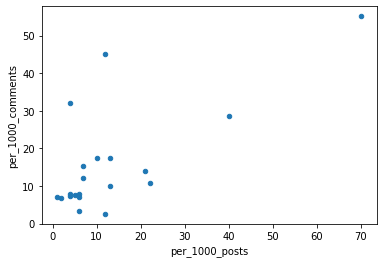

In [17]:
# do a quick eyeball test
chart_df[["per_1000_posts", "per_1000_comments"]].plot(kind="scatter", x="per_1000_posts", y="per_1000_comments")

In [18]:
# the code in this sell is what I used to download the png images of the emojis to use.
# unfortunately because the emoji descriptions are not standardized, this was a very manual process/
# emoji pngs were put in the ./emoji/ directory and named after the sapcymoji emoji_desc

# def make_clickable(val):
#     # target _blank to open new window
#     return '<a target="_blank" href="{}">{}</a>'.format(val, val)
# chart_df["emoji_desc"].str.replace(" ", "-").apply(lambda x: f"https://emojipedia.org/openmoji/13.0/{x}")\
#     .reset_index().style.format({'emoji_desc': make_clickable})

## Code below is what is used to create the actual plot and annotations

In [19]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [20]:
plt.style.use('seaborn')

In [21]:
def getImage(path):
    return OffsetImage(plt.imread(path), zoom=.18)

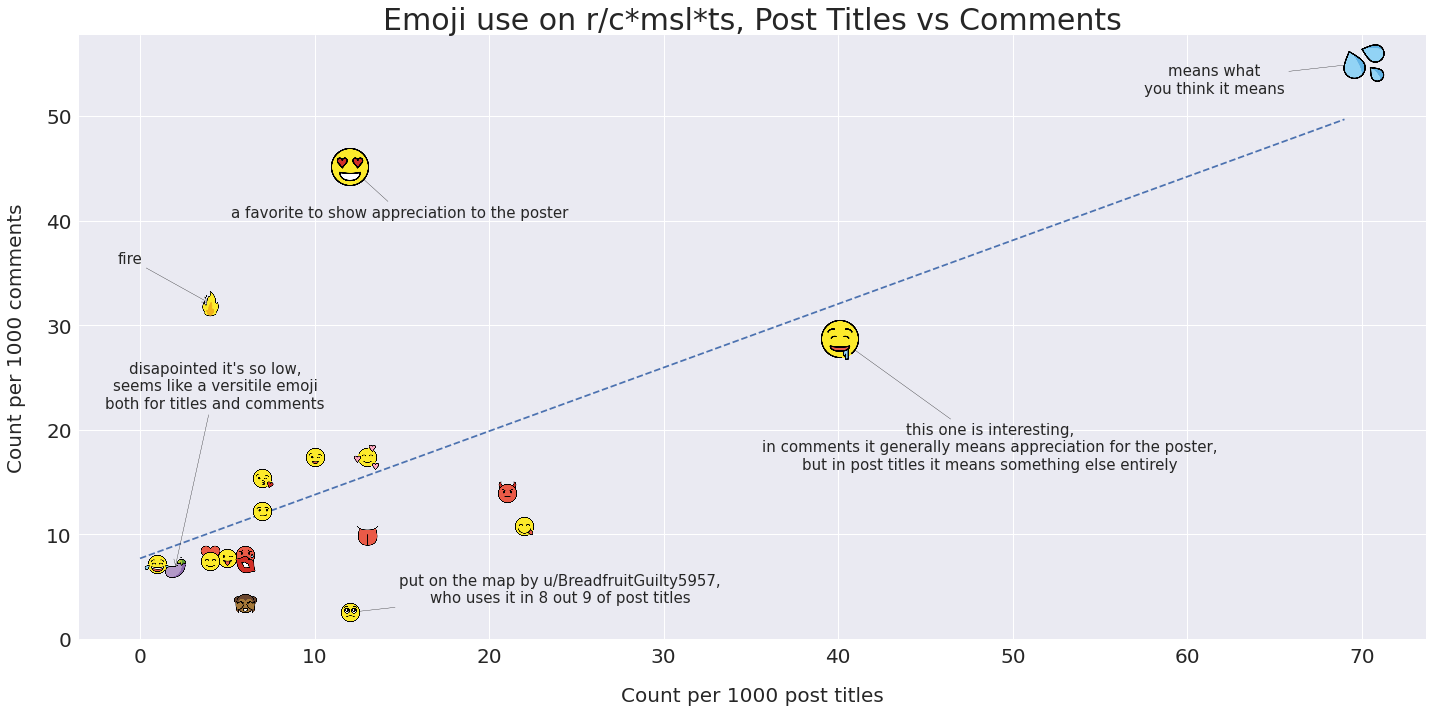

In [22]:
fig, ax = plt.subplots(figsize=(20,10))
# define x, y
x, y = chart_df['per_1000_posts'], chart_df['per_1000_comments']

#base scatter
ax.scatter(x,y, s=1)

# add a regression line, for some reason
m, b = np.polyfit(x, y, 1)
ax.plot(range(70), m*range(70)+b, ls="--")

# add in emjois as markers
imgs = [
    ax.add_artist(
        AnnotationBbox(getImage(f'./emoji/{emoji.emoji_desc.replace(" ","-")}.png'),
                      (emoji.per_1000_posts, emoji.per_1000_comments),
                       frameon=False
                      )
    )
    for emoji in chart_df.itertuples()
]

## anotate sweat droplets
emoji = chart_df.query('emoji_desc == "sweat droplets"').iloc[0]
ax.annotate(
    "means what\nyou think it means",
    (emoji['per_1000_posts'], emoji["per_1000_comments"]),
    fontsize=15,
    horizontalalignment='center',
    xytext = (-150, -30),
        textcoords="offset pixels",
        arrowprops=dict(
                     arrowstyle="->")
)

## anotate drooling face
emoji = chart_df.query('emoji_desc == "drooling face"').iloc[0]
ax.annotate(
    "this one is interesting,\nin comments it generally means appreciation for the poster,\nbut in post titles it means something else entirely",
    (emoji['per_1000_posts'], emoji["per_1000_comments"]),
    fontsize=15,
    horizontalalignment='center',
    xytext = (150, -130),
        textcoords="offset pixels",
        arrowprops=dict(
                     arrowstyle="->")
)

## anotate sweat droplets
emoji = chart_df.query('emoji_desc == "fire"').iloc[0]
ax.annotate(
    "fire",
    (emoji['per_1000_posts'], emoji["per_1000_comments"]),
    fontsize=15,
    horizontalalignment='center',
    xytext = (-80, 40),
        textcoords="offset pixels",
        arrowprops=dict(
                     arrowstyle="->")
)

## anotate sweat droplets
emoji = chart_df.query('emoji_desc == "smiling face with heart-eyes"').iloc[0]
ax.annotate(
    "a favorite to show appreciation to the poster",
    (emoji['per_1000_posts'], emoji["per_1000_comments"]),
    fontsize=15,
    horizontalalignment='center',
    xytext = (50, -50),
        textcoords="offset pixels",
        arrowprops=dict(
                     arrowstyle="->")
)

## anotate pleading face
emoji = chart_df.query('emoji_desc == "pleading face"').iloc[0]
ax.annotate(
    "put on the map by u/BreadfruitGuilty5957,\nwho uses it in 8 out 9 of post titles",
    (emoji['per_1000_posts'], emoji["per_1000_comments"]),
    fontsize=15,
    horizontalalignment='center',
    xytext = (210, 10),
        textcoords="offset pixels",
        arrowprops=dict(
                     arrowstyle="->")
)

## anotate pleading face
emoji = chart_df.query('emoji_desc == "eggplant"').iloc[0]
ax.annotate(
    "disapointed it's so low,\nseems like a versitile emoji\nboth for titles and comments",
    (emoji['per_1000_posts'], emoji["per_1000_comments"]),
    fontsize=15,
    horizontalalignment='center',
    xytext = (40, 160),
        textcoords="offset pixels",
        arrowprops=dict(
                     arrowstyle="->")
)


# x and y labels and ticks
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel("Count per 1000 post titles", size=20, labelpad=20)
plt.ylabel("Count per 1000 comments", size=20,labelpad=20)
plt.title("Emoji use on r/c*msl*ts, Post Titles vs Comments", size=30)
plt.tight_layout()
plt.savefig("emoji_use.png")